# OOI Sea Lion TensorFlow Lite Detection Example

Author: Ian Black\
Date: 2022-04-28

#### What is the goal of this example?
The goal of this example is to show you how to run a TensorFlow Lite object detection model on an image. You will be using a pretrained model to perform object detection for sea lions on OOI buoys.

#### What will the model run on?
The model is intended to be run on mobile and edge devices, but it will also work on devices that have tensorflow core.
***

## Training or Downloading a Model

If you want to train your own model, you can follow the training [guide](https://github.com/oceanobservatories/ooi-data-explorations/tree/master/python/examples/tensorflow).

Otherwise, you can download a couple of pre-trained models from [Kaggle](https://www.kaggle.com/datasets/blackia/ooi-sealions). There you will find a folder that contains tflite models. Simply download the dataset and extract the folders. Once extracted, make note of the absolute path of the model and add it to the User Defined Variables section.

## User Defined Variables

In [1]:
model_path = 'C:/Users/Ian/Desktop/ooi-sealions/models/ooi_sealions_b8_e100.tflite'
test_images_location = 'C:/Users/Ian/Desktop/ooi-sealions/test'

## Imports

This example requires tensorflow (if running on a Windows or Darwin machine), tensorflow lite (if running on a Raspberry Pi), and opencv. These can all be installed with pip.

If on Windows or Darwin..
```
pip install tensorflow
pip install tflite-support
pip install opencv-python
```

And if on a Raspberry Pi...
```
pip install tflite-runtime
pip install opencv-python-headless
```


In [2]:
import cv2
import json
import numpy as np
import os
import platform
from PIL import Image
import random
import re
import requests
from tflite_support import metadata
import urllib

## Setup
We will need some helper functions (from the collapsed cell below). These were taken from this [Google Colab example](https://colab.research.google.com/github/khanhlvg/tflite_raspberry_pi/blob/main/object_detection/Train_custom_model_tutorial.ipynb).

In [3]:
# @title Operating Classes and Functions
# @markdown This cell was copied from this example: https://colab.research.google.com/github/khanhlvg/tflite_raspberry_pi/blob/main/object_detection/Train_custom_model_tutorial.ipynb

from typing import List, NamedTuple

opersys = platform.system()
if opersys == 'Windows' or opersys == 'Darwin':
    import tensorflow as tf
    Interpreter = tf.lite.Interpreter
    load_delegate = tf.lite.experimental.load_delegate
else:
    import tflite_runtime_interpreter as tflite
    Interpreter = tflite.Interpreter
    load_delegate = tflite.experimental.load_delegate
    
# pylint: enable=g-import-not-at-top


class ObjectDetectorOptions(NamedTuple):
  """A config to initialize an object detector."""

  enable_edgetpu: bool = False
  """Enable the model to run on EdgeTPU."""

  label_allow_list: List[str] = None
  """The optional allow list of labels."""

  label_deny_list: List[str] = None
  """The optional deny list of labels."""

  max_results: int = -1
  """The maximum number of top-scored detection results to return."""

  num_threads: int = 1
  """The number of CPU threads to be used."""

  score_threshold: float = 0.0
  """The score threshold of detection results to return."""


class Rect(NamedTuple):
  """A rectangle in 2D space."""
  left: float
  top: float
  right: float
  bottom: float


class Category(NamedTuple):
  """A result of a classification task."""
  label: str
  score: float
  index: int


class Detection(NamedTuple):
  """A detected object as the result of an ObjectDetector."""
  bounding_box: Rect
  categories: List[Category]


def edgetpu_lib_name():
  """Returns the library name of EdgeTPU in the current platform."""
  return {
      'Darwin': 'libedgetpu.1.dylib',
      'Linux': 'libedgetpu.so.1',
      'Windows': 'edgetpu.dll',
  }.get(platform.system(), None)


class ObjectDetector:
  """A wrapper class for a TFLite object detection model."""

  _OUTPUT_LOCATION_NAME = 'location'
  _OUTPUT_CATEGORY_NAME = 'category'
  _OUTPUT_SCORE_NAME = 'score'
  _OUTPUT_NUMBER_NAME = 'number of detections'

  def __init__(
      self,
      model_path: str,
      options: ObjectDetectorOptions = ObjectDetectorOptions()
  ) -> None:
    """Initialize a TFLite object detection model.
    Args:
        model_path: Path to the TFLite model.
        options: The config to initialize an object detector. (Optional)
    Raises:
        ValueError: If the TFLite model is invalid.
        OSError: If the current OS isn't supported by EdgeTPU.
    """

    # Load metadata from model.
    displayer = metadata.MetadataDisplayer.with_model_file(model_path)

    # Save model metadata for preprocessing later.
    model_metadata = json.loads(displayer.get_metadata_json())
    process_units = model_metadata['subgraph_metadata'][0]['input_tensor_metadata'][0]['process_units']
    mean = 0.0
    std = 1.0
    for option in process_units:
      if option['options_type'] == 'NormalizationOptions':
        mean = option['options']['mean'][0]
        std = option['options']['std'][0]
    self._mean = mean
    self._std = std

    # Load label list from metadata.
    file_name = displayer.get_packed_associated_file_list()[0]
    label_map_file = displayer.get_associated_file_buffer(file_name).decode()
    label_list = list(filter(lambda x: len(x) > 0, label_map_file.splitlines()))
    self._label_list = label_list

    # Initialize TFLite model.
    if options.enable_edgetpu:
      if edgetpu_lib_name() is None:
        raise OSError("The current OS isn't supported by Coral EdgeTPU.")
      interpreter = Interpreter(
          model_path=model_path,
          experimental_delegates=[load_delegate(edgetpu_lib_name())],
          num_threads=options.num_threads)
    else:
      interpreter = Interpreter(
          model_path=model_path, num_threads=options.num_threads)

    interpreter.allocate_tensors()
    input_detail = interpreter.get_input_details()[0]

    # From TensorFlow 2.6, the order of the outputs become undefined.
    # Therefore we need to sort the tensor indices of TFLite outputs and to know
    # exactly the meaning of each output tensor. For example, if
    # output indices are [601, 599, 598, 600], tensor names and indices aligned
    # are:
    #   - location: 598
    #   - category: 599
    #   - score: 600
    #   - detection_count: 601
    # because of the op's ports of TFLITE_DETECTION_POST_PROCESS
    # (https://github.com/tensorflow/tensorflow/blob/a4fe268ea084e7d323133ed7b986e0ae259a2bc7/tensorflow/lite/kernels/detection_postprocess.cc#L47-L50).
    sorted_output_indices = sorted(
        [output['index'] for output in interpreter.get_output_details()])
    self._output_indices = {
        self._OUTPUT_LOCATION_NAME: sorted_output_indices[0],
        self._OUTPUT_CATEGORY_NAME: sorted_output_indices[1],
        self._OUTPUT_SCORE_NAME: sorted_output_indices[2],
        self._OUTPUT_NUMBER_NAME: sorted_output_indices[3],
    }

    self._input_size = input_detail['shape'][2], input_detail['shape'][1]
    self._is_quantized_input = input_detail['dtype'] == np.uint8
    self._interpreter = interpreter
    self._options = options

  def detect(self, input_image: np.ndarray) -> List[Detection]:
    """Run detection on an input image.
    Args:
        input_image: A [height, width, 3] RGB image. Note that height and width
          can be anything since the image will be immediately resized according
          to the needs of the model within this function.
    Returns:
        A Person instance.
    """
    image_height, image_width, _ = input_image.shape

    input_tensor = self._preprocess(input_image)

    self._set_input_tensor(input_tensor)
    self._interpreter.invoke()

    # Get all output details
    boxes = self._get_output_tensor(self._OUTPUT_LOCATION_NAME)
    classes = self._get_output_tensor(self._OUTPUT_CATEGORY_NAME)
    scores = self._get_output_tensor(self._OUTPUT_SCORE_NAME)
    count = int(self._get_output_tensor(self._OUTPUT_NUMBER_NAME))

    return self._postprocess(boxes, classes, scores, count, image_width,
                             image_height)

  def _preprocess(self, input_image: np.ndarray) -> np.ndarray:
    """Preprocess the input image as required by the TFLite model."""

    # Resize the input
    input_tensor = cv2.resize(input_image, self._input_size)

    # Normalize the input if it's a float model (aka. not quantized)
    if not self._is_quantized_input:
      input_tensor = (np.float32(input_tensor) - self._mean) / self._std

    # Add batch dimension
    input_tensor = np.expand_dims(input_tensor, axis=0)

    return input_tensor

  def _set_input_tensor(self, image):
    """Sets the input tensor."""
    tensor_index = self._interpreter.get_input_details()[0]['index']
    input_tensor = self._interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

  def _get_output_tensor(self, name):
    """Returns the output tensor at the given index."""
    output_index = self._output_indices[name]
    tensor = np.squeeze(self._interpreter.get_tensor(output_index))
    return tensor

  def _postprocess(self, boxes: np.ndarray, classes: np.ndarray,
                   scores: np.ndarray, count: int, image_width: int,
                   image_height: int) -> List[Detection]:
    """Post-process the output of TFLite model into a list of Detection objects.
    Args:
        boxes: Bounding boxes of detected objects from the TFLite model.
        classes: Class index of the detected objects from the TFLite model.
        scores: Confidence scores of the detected objects from the TFLite model.
        count: Number of detected objects from the TFLite model.
        image_width: Width of the input image.
        image_height: Height of the input image.
    Returns:
        A list of Detection objects detected by the TFLite model.
    """
    results = []

    # Parse the model output into a list of Detection entities.
    for i in range(count):
      if scores[i] >= self._options.score_threshold:
        y_min, x_min, y_max, x_max = boxes[i]
        bounding_box = Rect(
            top=int(y_min * image_height),
            left=int(x_min * image_width),
            bottom=int(y_max * image_height),
            right=int(x_max * image_width))
        class_id = int(classes[i])
        category = Category(
            score=scores[i],
            label=self._label_list[class_id],  # 0 is reserved for background
            index=class_id)
        result = Detection(bounding_box=bounding_box, categories=[category])
        results.append(result)

    # Sort detection results by score ascending
    sorted_results = sorted(
        results,
        key=lambda detection: detection.categories[0].score,
        reverse=True)

    # Filter out detections in deny list
    filtered_results = sorted_results
    if self._options.label_deny_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label not in self.
              _options.label_deny_list, filtered_results))

    # Keep only detections in allow list
    if self._options.label_allow_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label in self._options.
              label_allow_list, filtered_results))

    # Only return maximum of max_results detection.
    if self._options.max_results > 0:
      result_count = min(len(filtered_results), self._options.max_results)
      filtered_results = filtered_results[:result_count]

    return filtered_results


_MARGIN = 10  # pixels
_ROW_SIZE = 10  # pixels
_FONT_SIZE = 1
_FONT_THICKNESS = 1
_TEXT_COLOR = (0, 0, 255)  # red


def visualize(
    image: np.ndarray,
    detections: List[Detection],
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detections: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detections:
    # Draw bounding_box
    start_point = detection.bounding_box.left, detection.bounding_box.top
    end_point = detection.bounding_box.right, detection.bounding_box.bottom
    cv2.rectangle(image, start_point, end_point, _TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    class_name = category.label
    probability = round(category.score, 2)
    result_text = class_name + ' (' + str(probability) + ')'
    text_location = (_MARGIN + detection.bounding_box.left,
                     _MARGIN + _ROW_SIZE + detection.bounding_box.top)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, _TEXT_COLOR, _FONT_THICKNESS)

  return image

We will also need to designate the threshold at which boxes should be displayed on the image. Values below this threshold are ignored. We can also setup some other options and designate our detector object.

In [4]:
detection_threshold = 0.5
options = ObjectDetectorOptions(num_threads=1,score_threshold=detection_threshold)
detector = ObjectDetector(model_path=model_path, options=options)

## Test: Multiple Detections In a Single Image
In this test, we will use a particular test image that is known to have multiple sea lions. We can see that the number of boxes is close to the number of sea lions. However, you may notice that the boxes may not capture the full length of a sea lion, or may include two sea lions within the same box. The buoy tower can occlude some portions of a sea lion, and given how the data was labeled, it may report two sea lions when there is only one.

Analyzing C:\Users\Ian\Desktop\ooi-sealions\test\20210506_010124.cam0.jpg.


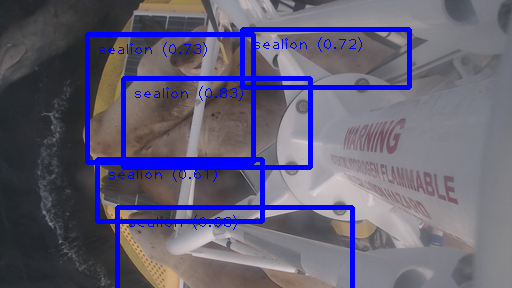

In [5]:
filename = '20210506_010124.cam0.jpg'
filepath = os.path.normpath(os.path.join(test_images_location,filename))
print(f"Analyzing {filepath}.")
image = Image.open(filepath).convert('RGB')
image.thumbnail((512, 512), Image.ANTIALIAS)
image_np = np.asarray(image)

# Run object detection estimation using the model.
detections = detector.detect(image_np)

# Draw keypoints and edges on input image
image_np = visualize(image_np, detections)

# Show the detection result
Image.fromarray(image_np)

In [6]:
detections

[Detection(bounding_box=Rect(left=123, top=78, right=310, bottom=167), categories=[Category(label='sealion', score=0.83203125, index=0)]),
 Detection(bounding_box=Rect(left=87, top=34, right=253, bottom=162), categories=[Category(label='sealion', score=0.73046875, index=0)]),
 Detection(bounding_box=Rect(left=242, top=29, right=409, bottom=87), categories=[Category(label='sealion', score=0.71875, index=0)]),
 Detection(bounding_box=Rect(left=117, top=207, right=352, bottom=291), categories=[Category(label='sealion', score=0.67578125, index=0)]),
 Detection(bounding_box=Rect(left=97, top=159, right=262, bottom=221), categories=[Category(label='sealion', score=0.61328125, index=0)])]

## Test: Another Image from Test Images

We can see from this one that a sea lion is detected on the solar panel, but the sea lions on the buoy well are not. It is clear that better labeling of data and more differently contrasted images are required to improve this model.


Analyzing C:\Users\Ian\Desktop\ooi-sealions\test\20210415_130126.cam0.jpg.


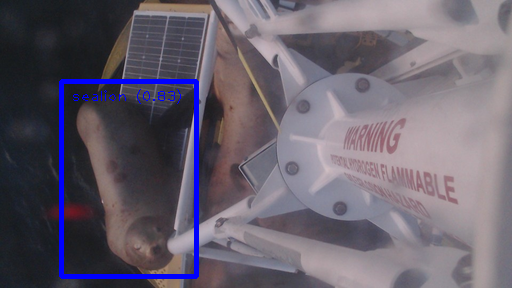

In [7]:
filename = '20210415_130126.cam0.jpg'
filepath = os.path.normpath(os.path.join(test_images_location,filename))
print(f"Analyzing {filepath}.")
image = Image.open(filepath).convert('RGB')
image.thumbnail((512, 512), Image.ANTIALIAS)
image_np = np.asarray(image)

# Run object detection estimation using the model.
detections = detector.detect(image_np)

# Draw keypoints and edges on input image
image_np = visualize(image_np, detections)

# Show the detection result
Image.fromarray(image_np)

In [8]:
detections

[Detection(bounding_box=Rect(left=61, top=81, right=196, bottom=276), categories=[Category(label='sealion', score=0.83203125, index=0)])]

## Test: Most Recent Image From Current Deployment

For this example, the most recent image for cam0 was `20220323_010127.cam0.jpg`. Running this code at a later date may produce a different image that may not have a sea lion.

Most Recent Image: 20220323_010127.cam0.jpg


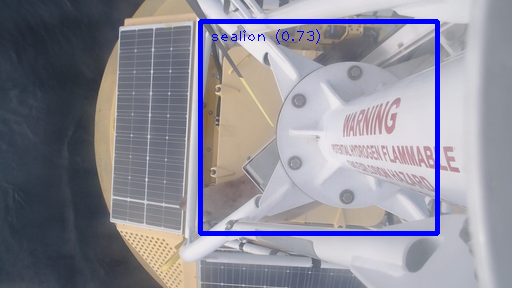

In [9]:
#Parse the html of the raw data archive to get unique deployments and filenames.
base = 'https://rawdata.oceanobservatories.org/files/CE07SHSM'
html = requests.get(base).text 
dep = np.sort(np.unique(re.findall('D[0-9]{5}',html)))[-1] #Find most recent deployment
html = requests.get('/'.join((base,dep,'cg_data','dcl11','vics','recent'))).text 
most_recent = np.sort(np.unique(re.findall('[0-9]{8}_[0-9]{6}\.cam0\.jpg',html)))[-1] #Find the most recent image.
img_url = '/'.join((base,dep,'cg_data','dcl11','vics','recent',most_recent))

temp_filename = 'ooi_sealion_temp.jpg'  #Create holder image.
temp_filepath = os.path.join(test_images_location,temp_filename)
urllib.request.urlretrieve(img_url,temp_filepath)

img = Image.open(temp_filepath).convert('RGB') #Convert image to RGB
img.thumbnail((512,512),Image.ANTIALIAS) #Resize image for input.
np_img = np.asarray(img) #Make the image a numpy array.

# Run object detection estimation using the model.
detections = detector.detect(np_img)

# Draw keypoints and edges on input image
np_img = visualize(np_img, detections)

# Show the detection result
print(f"Most Recent Image: {most_recent}")
Image.fromarray(np_img)

In [10]:
detections

[Detection(bounding_box=Rect(left=200, top=21, right=437, bottom=233), categories=[Category(label='sealion', score=0.73046875, index=0)])]